In [1]:
import sys, os
import argparse

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "./../../../../")))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "./../../../")))

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "")))

In [2]:
from fedml_api.data_preprocessing.cifar10.data_loader import load_partition_data_cifar10
from fedml_api.standalone.fedavg.my_model_trainer_classification import MyModelTrainer as MyModelTrainerCLS
from fedml_api.model.contrastive_cv.resnet_with_embedding import Resnet56

import torch
from torch import nn
from collections import OrderedDict
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
import pickle

# from triplet_loss import TripletLoss
from hard_triplet_loss import TripletLoss

In [3]:
dataset = 'cifar10'
data_dir = "./../../../data/cifar10"
partition_method = 'hetero'
# partition_method = 'homo'
partition_alpha = 0.5
client_num_in_total = 3
batch_size = 100
total_epochs = 500
save_model_path = 'model/client_{0}_triplet_epochs_{1}.pt'

device = 'cuda:1'

In [4]:
with open(f'dataset_{partition_method}_{client_num_in_total}.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [5]:
class Client(object):
    def __init__(self, client_index, train_data_local_dict, train_data_local_num_dict, test_data_local_dict, device, model):
        self.id = client_index
        self.train_data = train_data_local_dict[self.id]
        self.local_sample_number = train_data_local_num_dict[self.id]
        self.test_local = test_data_local_dict[self.id]
        
        self.device = device
        self.model = model

In [6]:
model = Resnet56(class_num=dataset[-1], neck='bnneck')
model.load_state_dict(torch.load(str.format('model/cs_{0}_{1}_client_{2}_oral_epochs_{3}.pt', client_num_in_total, partition_method, 0, 500)))
# [train_data_num, test_data_num, train_data_global, test_data_global, \
# #             train_data_local_num_dict, train_data_local_dict, test_data_local_dict, \
# #             class_num]
# model.load_state_dict(torch.load(str.format('model/client_{0}_triplet_epochs_{1}.pt', 0, 399)))
client_1 = Client(0, dataset[5], dataset[4], dataset[6], device, model)

In [7]:
def extract_features(model, data_loader,device):
    model.to(device)
    model.eval()
    
    features = []
    labels = []
    
    with torch.no_grad():
        for batch_idx, (x, l) in enumerate(data_loader):
            x, l = x.to(device), l.to(device)
            
            score, feats = model(x)
#             print(feats.shape)
            for feat, label in zip(feats, l):
                features.append(feat.cpu())
                labels.append(label.cpu())
    return features, labels

features, labels = extract_features(client_1.model, client_1.train_data, device)

In [8]:
from collections import Counter
ls = np.array([int(l) for l in labels])
counter_result = Counter(ls)
print(Counter(ls))

Counter({7: 4100, 4: 3174, 9: 2572, 5: 2335, 1: 1202, 6: 849, 2: 842, 3: 214, 0: 9, 8: 3})


In [9]:
# class imbalance sample
# ks = counter_result.keys()
def get_index(lst, item):
    return [i for i in range(len(lst)) if lst[i]==item]

sampled_idx = []
# ids = np.random.randint(0, 9, size=5)
# print(idx)
for k, v in counter_result.items():
#     print(f'{k}-{v}')
    idx = get_index(ls, k)
#     print(len(idx))
#     print(k)
    sampled_idx.extend(random.sample(idx, 100 if v>=100 else v))
#     if k in ids:
#         sampled_idx.extend(random.sample(idx, 100 if v>=100 else 0))
    
# print(len(sampled_idx))

812


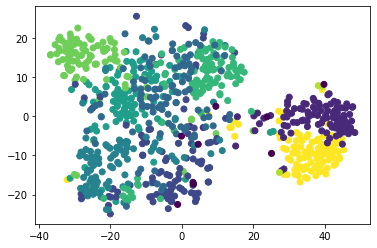

In [10]:
# print(shape(features))
# print(np.array(features[0][0]))
# print(features[0])
# print(np.array(features[0][0]).shape)
# print(torch.stack(labels).shape)

plot_features = torch.squeeze(torch.stack(features),dim=1)
plot_features = plot_features.numpy()[sampled_idx]
# for idx in sampled_idx:
#     plt_f.append(plot_features[idx])
print(len(plot_features))
source_features = F.normalize(torch.from_numpy(plot_features), dim=1)


tsne = TSNE(n_components=2, init='pca', perplexity=30)
Y = tsne.fit_transform(source_features)

plt.scatter(Y[:, 0], Y[:, 1], c=ls[sampled_idx])
plt.show()

In [11]:
model = Resnet56(class_num=dataset[-1], neck='bnneck')
model.load_state_dict(torch.load(str.format('model/cs_{0}_{1}_client_{2}_triplet_epochs_{3}.pt', client_num_in_total, partition_method, 0, 300)))
# [train_data_num, test_data_num, train_data_global, test_data_global, \
# #             train_data_local_num_dict, train_data_local_dict, test_data_local_dict, \
# #             class_num]
# model.load_state_dict(torch.load(str.format('model/client_{0}_triplet_epochs_{1}.pt', 0, 399)))
client_2 = Client(0, dataset[5], dataset[4], dataset[6], device, model)

In [12]:
features2, labels2 = extract_features(client_2.model, client_2.train_data, device)

In [13]:
ls = np.array([int(l) for l in labels2])
counter_result = Counter(ls)
print(Counter(ls))

Counter({7: 4100, 4: 3174, 9: 2566, 5: 2334, 1: 1201, 6: 850, 2: 848, 3: 215, 0: 9, 8: 3})


812


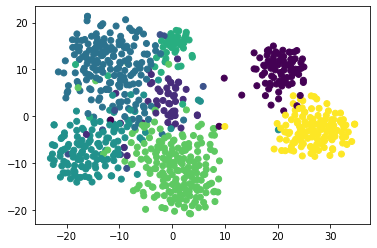

In [14]:
# print(shape(features))
# print(np.array(features[0][0]))
# print(features[0])
# print(np.array(features[0][0]).shape)
# print(torch.stack(labels).shape)

plot_features = torch.squeeze(torch.stack(features2),dim=1)
plot_features = plot_features.numpy()[sampled_idx]
# for idx in sampled_idx:
#     plt_f.append(plot_features[idx])
print(len(plot_features))
source_features = F.normalize(torch.from_numpy(plot_features), dim=1)


tsne = TSNE(n_components=2, init='pca', perplexity=30)
Y = tsne.fit_transform(source_features)

plt.scatter(Y[:, 0], Y[:, 1], c=ls[sampled_idx])
plt.show()